## CX Insights: Análise de Indicadores de Atendimento e Proposta de Melhoria Operacional

In [41]:
#Importar as bibliotecas necessárias (usando o Colab):
import pandas as pd
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import datetime
import numpy as np


In [9]:
#Vincular ao caminho do drive que consta minha planilha e puxei o arquivo (você deve montar o drive e ajustar o caminho do arquivo, caso use seu notebook em outro ambiente):
drive.mount('/content/drive')
caminho_arquivo = '/content/drive/MyDrive/Dados para análise/NPS e TMA/BaseNPSeTMA.xlsx'
df = pd.read_excel(caminho_arquivo)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Nome,Supervisor,TempodeCasa,Detrator,Neutro,Promotor,Total.avaliado,TMA,Total.atendido,NPS
0,Ana Vitória Gonçalves,Enrico Teixeira,Novato,5,1,10,8,00:15:40,200,31.0
1,Lucas Gabriel Silveira,Isis Fogaça,Veterano,0,0,6,6,00:12:35,300,100.0
2,Raul da Cunha,Rafael Novaes,Veterano,0,0,5,5,00:10:39,250,100.0
3,Francisco Araãºjo,Isis Fogaça,Veterano,0,0,5,5,00:09:04,290,100.0
4,Kaique Melo,Isis Fogaça,Veterano,0,0,5,5,00:14:13,280,100.0


In [11]:
#Mudando o tipo dos dados, para que os númericos sejam reconhecidos como tal (int), ou seja, converter colunas de string para int:
df['Promotor'] = df['Promotor'].astype(int)
df['Neutro'] = df['Neutro'].astype(int)
df['Detrator'] = df['Detrator'].astype(int)
df['Total.avaliado'] = df['Total.avaliado'].astype(int)
df['Total.atendido'] = df['Total.atendido'].astype(int)
df['NPS'] = df['NPS'].astype(float)
df['TMA'] = pd.to_timedelta(df['TMA'].astype(str))

#Reordenando com base no NPS (melhor NPS para o pior):
df = df.sort_values(by='NPS', ascending=False)
df.head()


,Nome,Supervisor,TempodeCasa,Detrator,Neutro,Promotor,Total.avaliado,TMA,Total.atendido,NPS
3,Francisco Araãºjo,Isis Fogaça,Veterano,0,0,5,5,0 days 00:09:04,290,100.0
4,Kaique Melo,Isis Fogaça,Veterano,0,0,5,5,0 days 00:14:13,280,100.0
5,Enzo Gabriel Freitas,Vitor Hugo Cardoso,Veterano,0,0,5,5,0 days 00:10:09,270,100.0
7,Vitória Moreira,Enrico Teixeira,Veterano,0,0,5,5,0 days 00:09:29,215,100.0
1,Lucas Gabriel Silveira,Isis Fogaça,Veterano,0,0,6,6,0 days 00:12:35,300,100.0


In [12]:
# Quartilização básica do NPS
df['NPS_Quartil'] = pd.qcut(df['NPS'].rank(method='first'), 4, labels=['Q4', 'Q3', 'Q2', 'Q1'])
df.head()

,Nome,Supervisor,TempodeCasa,Detrator,Neutro,Promotor,Total.avaliado,TMA,Total.atendido,NPS,NPS_Quartil
3,Francisco Araãºjo,Isis Fogaça,Veterano,0,0,5,5,0 days 00:09:04,290,100.0,Q1
4,Kaique Melo,Isis Fogaça,Veterano,0,0,5,5,0 days 00:14:13,280,100.0,Q1
5,Enzo Gabriel Freitas,Vitor Hugo Cardoso,Veterano,0,0,5,5,0 days 00:10:09,270,100.0,Q1
7,Vitória Moreira,Enrico Teixeira,Veterano,0,0,5,5,0 days 00:09:29,215,100.0,Q1
1,Lucas Gabriel Silveira,Isis Fogaça,Veterano,0,0,6,6,0 days 00:12:35,300,100.0,Q1


In [43]:
#NPS médio por quartil
# Agrupar por quartil e somar total de avaliações (com observed=True para evitar warnings)
nps_ponderado = (
    df.groupby('NPS_Quartil', observed=True)

#O comando abaixo aplica a função media_ponderada_nps para cada grupo separado e arredonda para 2 casas decimais
     .apply(media_ponderada_nps, include_groups=False)
      .round(2)
)

print(nps_ponderado)

#Se quisesse exportar, basta usar o comando abaixo:
#nps_ponderado.to_csv('nps_ponderado_quartil.csv')
#files.download('nps_ponderado_quartil.csv')

NPS_Quartil
Q4    20.16
Q3    32.27
Q2    44.03
Q1    62.89
dtype: float64


# 📊E que tal um gráfico com essa informação?

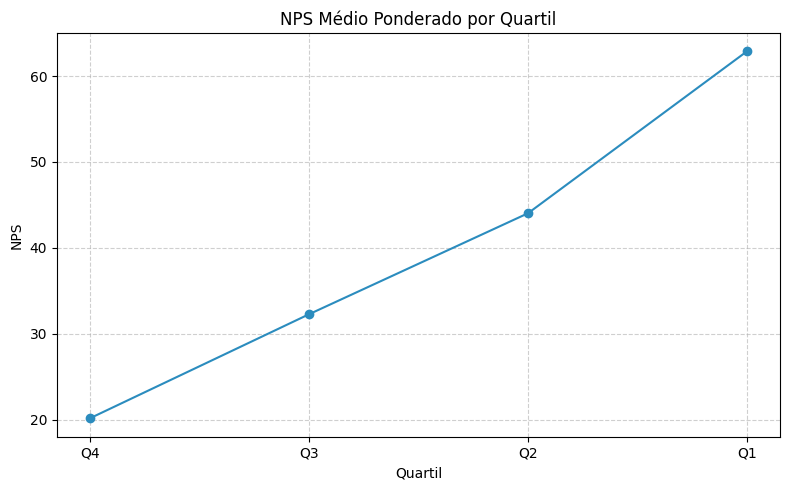

In [46]:
# Usar os segundos convertidos para minutos para o gráfico

plt.figure(figsize=(8, 5))
plt.plot(nps_ponderado.sort_index(), marker='o', linestyle='-', color='#2b8cbe')

# Estilização
plt.title('NPS Médio Ponderado por Quartil')
plt.xlabel('Quartil')
plt.ylabel('NPS')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# TMA médio por quartil: Será que o operador Q1 em NPS tem o maior TMA? Vamos verificar o TMA para cada quartil de NPS



In [60]:
# Agora que já quartilizamos a base de NPS, vamos quartilizar o TMA e seguir com a média por quartil
# Converter TMA para segundos para facilitar o cálculo
df['TMA_segundos'] = df['TMA'].dt.total_seconds()

# Calcular tempo total (TMA_segundos * total atendido)
df['tempo_total'] = df['TMA_segundos'] * df['Total.atendido']

# Agrupar por quartil e somar tempo e atendimentos (com observed=True para evitar warnings)
agrupadoTMA = df.groupby('NPS_Quartil', observed=True)[['tempo_total', 'Total.atendido']].sum()

# Calcular média ponderada em segundos
agrupadoTMA['TMA_ponderado_seg'] = agrupadoTMA['tempo_total'] / agrupadoTMA['Total.atendido']

# Converter segundos de volta para HH:MM:SS
agrupadoTMA['TMA_ponderado'] = agrupadoTMA['TMA_ponderado_seg'].apply(lambda x: pd.to_timedelta(x, unit='s'))

# Exibir apenas o tempo formatado limpo (sem 0 days e sem milissegundos)
agrupadoTMA['TMA_ponderado_formatado'] = agrupadoTMA['TMA_ponderado'].apply(lambda x: str(x).split('.')[0].split()[-1])

# Visualizar o resultado final
agrupadoTMA[['TMA_ponderado_formatado']]

#Transformar em df
df_tma_quartil = agrupadoTMA[['TMA_ponderado_formatado']].reset_index()


# 📊E que tal um gráfico com essa informação?

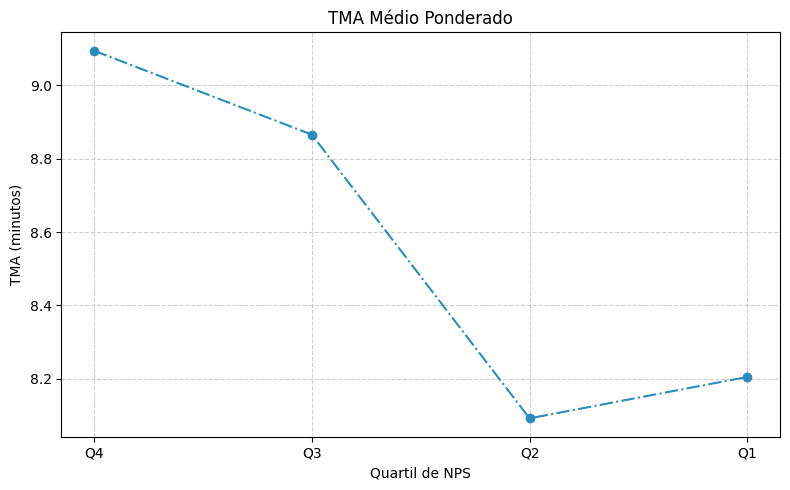

In [68]:
# Vamos usar os segundos convertidos para minutos para o gráfico e por isso irei jogar logo em df para facilitar

dados_linha = agrupadoTMA['TMA_ponderado_seg'] / 60  # converte para minutos


plt.figure(figsize=(8, 5))
plt.plot(dados_linha.sort_index(), marker='o', linestyle='-.', color='#2b8cbe')

# Estilização
plt.title('TMA Médio Ponderado')
plt.xlabel('Quartil de NPS')
plt.ylabel('TMA (minutos)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


Mas, o tempo de casa tem influência? Os novatos possuem um TMA muito elevado em relação aos veteranos?

In [66]:
#TMA por tempo de casa
# Garantir que TMA esteja em segundos
df['TMA_segundos'] = df['TMA'].dt.total_seconds()

# Calcular tempo total (TMA * total atendido)
df['tempo_total'] = df['TMA_segundos'] * df['Total.atendido']

# Agrupar por categoria (novato/veterano)
grupo_casa = df.groupby('TempodeCasa')[['tempo_total', 'Total.atendido']].sum()

# Calcular TMA ponderado
grupo_casa['TMA_ponderado_seg'] = grupo_casa['tempo_total'] / grupo_casa['Total.atendido']
grupo_casa['TMA_formatado'] = grupo_casa['TMA_ponderado_seg'].apply(lambda x: str(pd.to_timedelta(x, unit='s')).split('.')[0].split()[-1])

# Exibir resultado formatado
grupo_casa[['TMA_formatado']]

,TMA_formatado
TempodeCasa,
Novato,00:08:53
Veterano,00:08:28


### 📊E se eu quiser um gráfico que facilite a visualização do TMA de geral, novatos e veteranos por quartil de NPS? Assim consigo concluir se o tempo de casa influencia no NPS, no TMA ou em ambos.

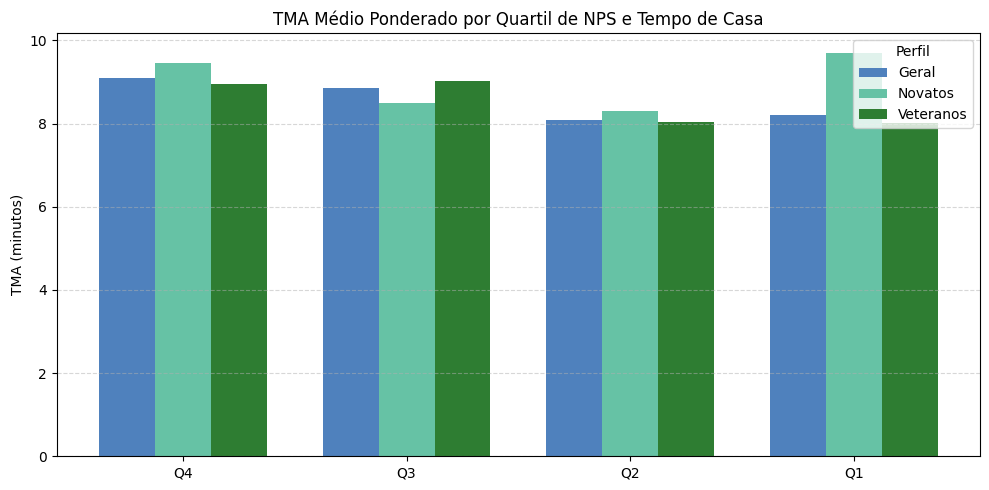

In [69]:
# Garantir que TMA esteja em segundos
df['TMA_segundos'] = df['TMA'].dt.total_seconds()
df['tempo_total'] = df['TMA_segundos'] * df['Total.atendido']

# Criar função para média ponderada por grupo
def tma_ponderado(grupo):
    tempo = grupo['tempo_total'].sum()
    total = grupo['Total.atendido'].sum()
    if total == 0:
        return None
    return tempo / total

# Calcular TMA geral por quartil
tma_geral = df.groupby('NPS_Quartil', observed=True).apply(tma_ponderado, include_groups=False)

# Calcular TMA por quartil + tempo de casa
tma_detalhado = df.groupby(['NPS_Quartil', 'TempodeCasa'], observed=True).apply(tma_ponderado, include_groups=False).unstack()

# Unir tudo
tabela = pd.DataFrame({
    'TMA Geral (seg)': tma_geral,
    'TMA Novatos (seg)': tma_detalhado.get('Novato'),
    'TMA Veteranos (seg)': tma_detalhado.get('Veterano')
})

# Converter para HH:MM:SS
tabela_formatada = tabela.copy()
for col in tabela.columns:
    tabela_formatada[col.replace('(seg)', '(formatado)')] = tabela[col].apply(
        lambda x: str(pd.to_timedelta(x, unit='s')).split('.')[0].split()[-1] if pd.notnull(x) else '-')

# Dados numéricos em minutos para plot
dados = tabela[['TMA Geral (seg)', 'TMA Novatos (seg)', 'TMA Veteranos (seg)']] / 60

# Configurações de plot
labels = dados.index.tolist()
x = np.arange(len(labels))  # posições
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))

# Barras agrupadas
ax.bar(x - width, dados['TMA Geral (seg)'], width, label='Geral', color='#4f81bd')
ax.bar(x, dados['TMA Novatos (seg)'], width, label='Novatos', color='#66C2A5')
ax.bar(x + width, dados['TMA Veteranos (seg)'], width, label='Veteranos', color='#2E7D32')

# Ajustes visuais
ax.set_ylabel('TMA (minutos)')
ax.set_title('TMA Médio Ponderado por Quartil de NPS e Tempo de Casa')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title='Perfil')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Para fechar essa primeira etapa, é interessante verificar quantos novatos e quantos veteranos temos em cada quartil de NPS!

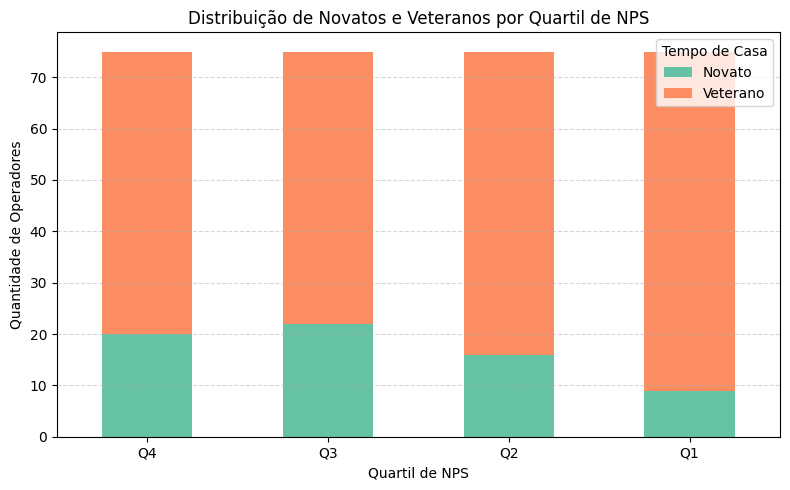

In [70]:
# Tabela cruzada: Quartil × Tempo de Casa
distribuicao = pd.crosstab(df['NPS_Quartil'], df['TempodeCasa'])

# Plotar a distribuição em gráfico de barras empilhadas
distribuicao.plot(kind='bar', stacked=True, figsize=(8, 5), color=['#66c2a5', '#fc8d62'])
plt.title('Distribuição de Novatos e Veteranos por Quartil de NPS')
plt.xlabel('Quartil de NPS')
plt.ylabel('Quantidade de Operadores')
plt.legend(title='Tempo de Casa')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Aqui já entendemos muito sobre o atendimento, mas será que temos diferenças significativas entre as equipes?

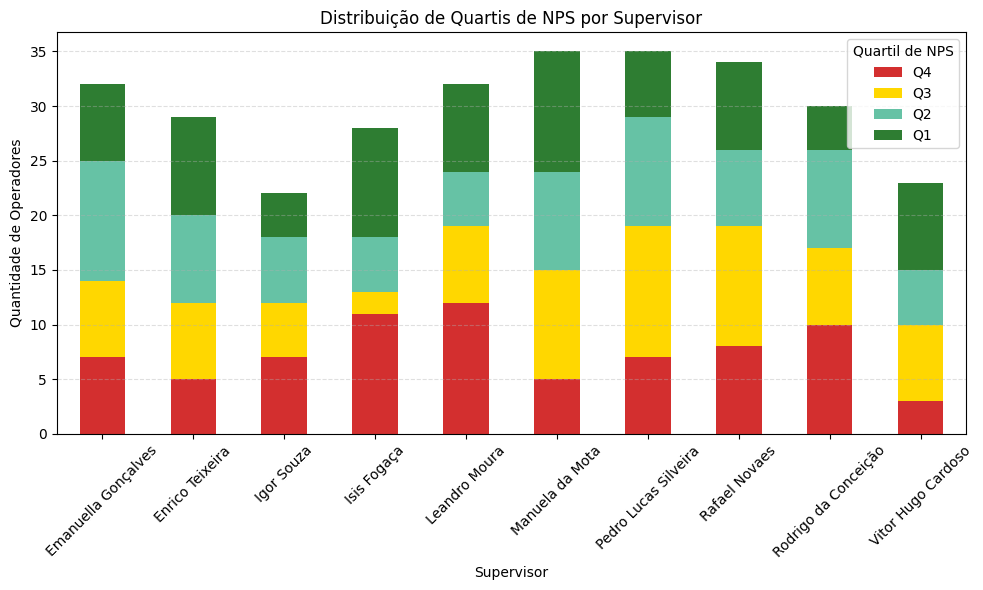

In [71]:
# Vamos criar uma tabela cruzada com contagem de operadores por quartil e por supervisor
tabela_quartis = pd.crosstab(df['Supervisor'], df['NPS_Quartil'])


# Plotar gráfico de barras empilhadas com cores por quartil
cores_personalizadas = {
    'Q4': '#D32F2F',   # vinho
    'Q3': '#FFD700',   # amarelo
    'Q2': '#66C2A5',   # azul anterior
    'Q1': '#2E7D32'    # verde
}

# Reordenar colunas se necessário para manter ordem Q4 → Q1
tabela_quartis = tabela_quartis[['Q4', 'Q3', 'Q2', 'Q1']]

# Plotar com as cores desejadas
tabela_quartis.plot(kind='bar', stacked=True, figsize=(10, 6),
                    color=[cores_personalizadas[q] for q in tabela_quartis.columns])

plt.title('Distribuição de Quartis de NPS por Supervisor')
plt.xlabel('Supervisor')
plt.ylabel('Quantidade de Operadores')
plt.legend(title='Quartil de NPS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

### Mas, se eu quiser um % de Q4 por equipe?

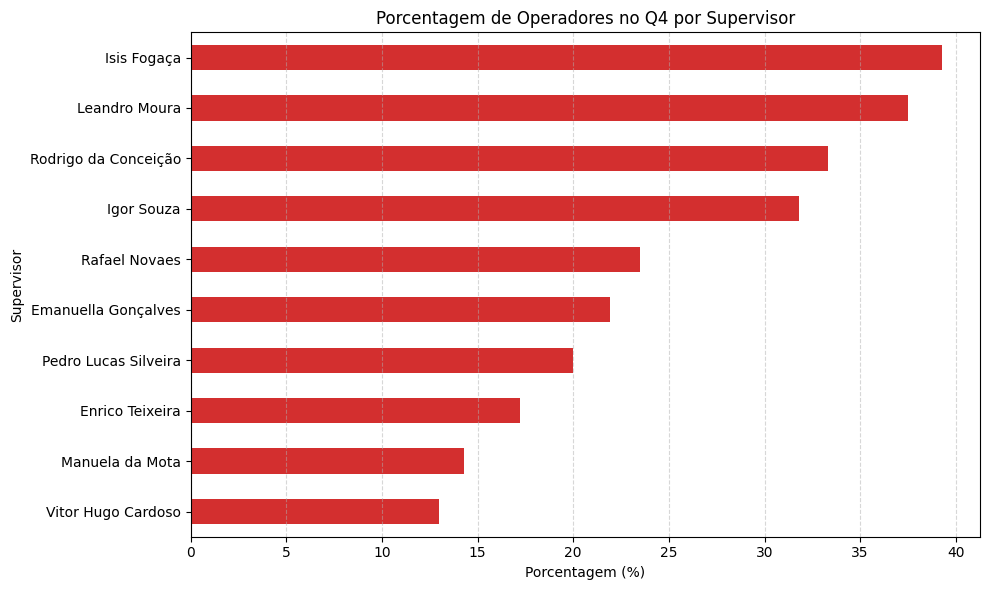

In [72]:
# Contagem total de operadores por supervisor
total_operadores = df.groupby('Supervisor')['Nome'].count()

# Contagem de operadores no Q4 por supervisor
q4_operadores = df[df['NPS_Quartil'] == 'Q4'].groupby('Supervisor')['Nome'].count()

# Calcular porcentagem
porcentagem_q4 = (q4_operadores / total_operadores * 100).fillna(0).sort_values(ascending=False)

# Exibir tabela formatada
porcentagem_q4 = porcentagem_q4.round(1)  # arredondar para 1 casa decimal
porcentagem_q4.name = 'Porcentagem_Q4 (%)'
porcentagem_q4

# Plotar gráfico
plt.figure(figsize=(10, 6))
porcentagem_q4.sort_values().plot(kind='barh', color='#D32F2F')

plt.title('Porcentagem de Operadores no Q4 por Supervisor')
plt.xlabel('Porcentagem (%)')
plt.ylabel('Supervisor')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Também podemos confirmar a variação de NPS por equipe!**

In [89]:
# Função para média ponderada de NPS por grupo
def media_ponderada_nps(grupo):
    nps_peso = (grupo['NPS'] * grupo['Total.avaliado']).sum()
    total_peso = grupo['Total.avaliado'].sum()
    return nps_peso / total_peso if total_peso != 0 else None

# Calcular NPS ponderado por supervisor
nps_sup = df.groupby('Supervisor', observed=True).apply(media_ponderada_nps, include_groups=False).round(2)
nps_sup.name = 'NPS Ponderado'

#Transformar em df
nps_sup = df.groupby('Supervisor', observed=True).apply(media_ponderada_nps, include_groups=False).round(2)
nps_sup.name = 'NPS Ponderado'

# Exibir a tabela
nps_sup = nps_sup.sort_values(ascending=False)
nps_sup

Supervisor
Emanuella Gonçalves     40.01
Enrico Teixeira         42.48
Igor Souza              36.28
Isis Fogaça             43.16
Leandro Moura           36.56
Manuela da Mota         41.84
Pedro Lucas Silveira    38.38
Rafael Novaes           37.32
Rodrigo da Conceição    34.83
Vitor Hugo Cardoso      41.76
Name: NPS Ponderado, dtype: float64


### Ótimo! Mas, não podemos esquecer de conferir o TMA por supervisor(equipe)

In [73]:
#TMA médio ponderado por supervisor
# Garantir que TMA esteja em formato timedelta e já tenha sido convertido corretamente:
df['TMA_segundos'] = df['TMA'].dt.total_seconds()
df['tempo_total'] = df['TMA_segundos'] * df['Total.atendido']

# Agrupar por supervisor e calcular o total de tempo e total de atendimentos
grupo_sup = df.groupby('Supervisor')[['tempo_total', 'Total.atendido']].sum()

# Calcular TMA médio ponderado em segundos
grupo_sup['TMA_ponderado_seg'] = grupo_sup['tempo_total'] / grupo_sup['Total.atendido']

# Converter para HH:MM:SS
grupo_sup['TMA_ponderado'] = grupo_sup['TMA_ponderado_seg'].apply(lambda x: pd.to_timedelta(x, unit='s'))
grupo_sup['TMA_formatado'] = grupo_sup['TMA_ponderado'].apply(lambda x: str(x).split('.')[0].split()[-1])

#Ordenar do maior TMA para o menor
grupo_sup_ordenado = grupo_sup.sort_values(by='TMA_ponderado_seg', ascending=False)

# Exibir somente a tabela final formatada

grupo_sup_ordenado[['TMA_formatado']]

,TMA_formatado
Supervisor,
Igor Souza,00:09:34
Rafael Novaes,00:09:09
Isis Fogaça,00:09:03
Manuela da Mota,00:08:51
Rodrigo da Conceição,00:08:22
Leandro Moura,00:08:19
Emanuella Gonçalves,00:08:18
Pedro Lucas Silveira,00:08:14
Vitor Hugo Cardoso,00:07:56


### Será que a quantidade de novatos por equipe gera impacto nesse resultado?

In [74]:
# Converter TMA para segundos
df['TMA_segundos'] = df['TMA'].dt.total_seconds()

# Função para calcular TMA ponderado por grupo interno (novato/veterano)
def calcular_tma_por_grupo(grupo):
    tempo_total = (grupo['TMA_segundos'] * grupo['Total.atendido']).sum()
    total_atend = grupo['Total.atendido'].sum()
    if total_atend == 0:
        return pd.NaT
    tma_seg = tempo_total / total_atend
    return pd.to_timedelta(tma_seg, unit='s')

# Agrupar por supervisor e tempo de casa
grupo_detalhado = df.groupby(['Supervisor', 'TempodeCasa'])

# Criar tabela com contagem e TMA
resultado = grupo_detalhado.agg(
    qtd=('Nome', 'count'),
    tma_seg=('TMA_segundos', lambda x: (x * df.loc[x.index, 'Total.atendido']).sum() / df.loc[x.index, 'Total.atendido'].sum())
).reset_index()

# Converter segundos em HH:MM:SS formatado
resultado['TMA_formatado'] = resultado['tma_seg'].apply(lambda x: str(pd.to_timedelta(x, unit='s')).split('.')[0].split()[-1])

# Pivotar para obter a estrutura final
tabela_final = resultado.pivot(index='Supervisor', columns='TempodeCasa', values=['qtd', 'TMA_formatado'])

# Organizar colunas com nomes amigáveis
tabela_final.columns = ['Qtd Novatos', 'Qtd Veteranos', 'TMA Novatos', 'TMA Veteranos']
tabela_final = tabela_final[['Qtd Novatos', 'TMA Novatos', 'Qtd Veteranos', 'TMA Veteranos']]

# Exibir resultado final
tabela_final

,Qtd Novatos,TMA Novatos,Qtd Veteranos,TMA Veteranos
Supervisor,,,,
Emanuella Gonçalves,9,00:08:22,23,00:08:17
Enrico Teixeira,7,00:10:40,22,00:07:02
Igor Souza,3,00:08:31,19,00:09:46
Isis Fogaça,10,00:10:28,18,00:08:18
Leandro Moura,5,00:06:25,27,00:08:41
Manuela da Mota,8,00:11:45,27,00:08:01
Pedro Lucas Silveira,8,00:08:35,27,00:08:09
Rafael Novaes,9,00:07:43,25,00:09:44
Rodrigo da Conceição,6,00:07:53,24,00:08:29


### Por fim, podemos montar uma tabela com os impactos princpais de cada equipe: % de Q4, TMA e % de novatos.

In [91]:
# Total de operadores por supervisor
total_operadores = df.groupby('Supervisor')['Nome'].count()

# Contagem de novatos por supervisor
novatos = df[df['TempodeCasa'] == 'Novato'].groupby('Supervisor')['Nome'].count()

# Calcular porcentagem
porcentagem_novatos = (novatos / total_operadores * 100).fillna(0).round(1)
porcentagem_novatos.name = 'Porcentagem Novatos (%)'

# Assumindo que você já tem:
# - porcentagem_q4
# - grupo_sup['TMA_ponderado_seg']

# Unir tudo
comparativo = pd.concat([
    nps_sup,                                  # Novo: NPS Ponderado
    porcentagem_q4,                           # % Q4
    grupo_sup['TMA_ponderado_seg'] / 60,      # TMA em minutos
    porcentagem_novatos                       # % Novatos
], axis=1)

# Renomear colunas para visualização
comparativo.columns = ['NPS','% no Q4', 'TMA (min)', '% Novatos']

# Arredondar TMA
comparativo['TMA (min)'] = comparativo['TMA (min)'].round(2)

# Ordenar pela % no Q4
comparativo = comparativo.sort_values(by='% no Q4', ascending=False)

# Exibir resultado
comparativo

,NPS,% no Q4,TMA (min),% Novatos
Supervisor,,,,
Isis Fogaça,43.16,39.3,9.06,35.7
Leandro Moura,36.56,37.5,8.32,15.6
Rodrigo da Conceição,34.83,33.3,8.38,20.0
Igor Souza,36.28,31.8,9.57,13.6
Rafael Novaes,37.32,23.5,9.16,26.5
Emanuella Gonçalves,40.01,21.9,8.31,28.1
Pedro Lucas Silveira,38.38,20.0,8.24,22.9
Enrico Teixeira,42.48,17.2,7.87,24.1
Manuela da Mota,41.84,14.3,8.87,22.9


## ✅ Conclusão Final

Este notebook consolidou uma análise exploratória e comparativa dos principais indicadores de atendimento — NPS e TMA — sob diferentes recortes operacionais, como tempo de casa e supervisores.

🔎 Identificamos padrões relevantes, como a relação entre tempo médio de atendimento e percepção do cliente, e destacamos oportunidades de melhoria com base na distribuição dos operadores por quartil.

📌 As informações obtidas podem orientar decisões estratégicas voltadas à eficiência operacional, aprimoramento de onboarding e direcionamento das lideranças.

---

🎯 Obrigada por acompanhar a análise!
Sinta-se à vontade para explorar o código, replicar os insights ou propor melhorias.
